<a href="https://colab.research.google.com/github/shprnu/donorp/blob/main/donorp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

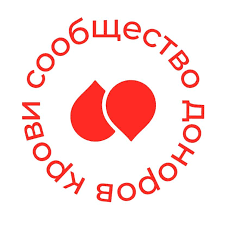

# **Анализ данных сайта DonorSearch**
**Цель проекта:** найти идеи для увеличения количества доноров и жертвователей, а также повысить частоту донаций.

## Подготовка к проекту

**Импорт необходимых библиотек**

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
PATH_DATASETS = '/content/drive/MyDrive/ColabNotebooks/datasets/'



> Google Colab, требует именно такой путь, при запуске через Git потребуется заменить на более короткий ('./datasets/')



**Загрузка данных для анализа**

In [3]:
users_anon_data = pd.read_csv(f'{PATH_DATASETS}users_anon_data.csv')
users_anon_data2 = pd.read_csv(f'{PATH_DATASETS}users_anon_data2.csv')

> users_anon_data.csv был разделен, так как github не загружает файлы больше 100Мб, далее таблицы будут объеденены



In [4]:
donations_plan = pd.read_csv(f'{PATH_DATASETS}anon_donations_plan.csv')
donations_anon = pd.read_csv(f'{PATH_DATASETS}donations_anon.csv')
clients_anon = pd.read_csv(f'{PATH_DATASETS}clients_anon.csv')
fundraisings_anon = pd.read_csv(f'{PATH_DATASETS}fundraisings_anon.csv')

Объединение users_anon_data и users_anon_data2 по общим столбцам

In [5]:
users_anon_data_all = pd.concat([users_anon_data, users_anon_data2], ignore_index=True)

## Предобработка данных

Функция для сводной информации по датасету, пропускам и дубликатам

In [6]:
def data_summary(df):
    return {
        "shape": df.shape,
        "missing_val": df.isnull().sum().sum(),
        "duplicates": df.duplicated().sum()
    }

Получение сводной информации по каждому датасету

In [7]:
summary = {
    "users_anon_data": data_summary(users_anon_data_all),
    "donations_plan": data_summary(donations_plan),
    "donations_anon": data_summary(donations_anon),
    "clients_anon": data_summary(clients_anon),
    "fundraisings_anon": data_summary(fundraisings_anon)
}

Вывод на экран

In [8]:
print("Общая информация по датасетам:")
for key in summary:
    print('Датасет [%s]' % key)
    print('- размер (%s, %s)' % (summary[key]['shape'][0], summary[key]['shape'][1]))
    print('- пропуски %s' % summary[key]['missing_val'])
    print('- дубликаты %s' % summary[key]['duplicates'])

Общая информация по датасетам:
Датасет [users_anon_data]
- размер (280111, 39)
- пропуски 0
- дубликаты 0
Датасет [donations_plan]
- размер (34186, 10)
- пропуски 0
- дубликаты 0
Датасет [donations_anon]
- размер (315750, 13)
- пропуски 0
- дубликаты 785
Датасет [clients_anon]
- размер (1379, 14)
- пропуски 0
- дубликаты 0
Датасет [fundraisings_anon]
- размер (40, 13)
- пропуски 43
- дубликаты 0


По результатам вывода:
* в датасете fundraisings_anon очень мало записей, чтобы предоставить объективную оценку по пожертвованиям (далее при анализе это допущение опускается)
* в датасете donations_anon есть дубликаты
* в датасете fundraisings_anon есть пропуски

**Удаление дубликатов**

In [9]:
donations_anon = donations_anon.drop_duplicates()

**Заполнение пропусков**

Пропуски в полях описания и цели сбора, предсказать и усреднить непредставляется возможным.


Вывод: создание универсальной функции, которая заполненяет числовые поля - 0, текстовые - пустыми строками.

In [10]:
def fill_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column].fillna("", inplace=True)
        else:
            df[column].fillna(0, inplace=True)
    return df

fundraisings_anon = fill_missing_values(fundraisings_anon)

**Обработка аномальных данных**


> Выявлены аномальные даты, которые на данном этапе обработать/удалить нельзя, так как затронет полезные данные/исказит текущие. Обработка аномальных дат будет непосредственно перед анализом.



**Преобразование типов данных**

Функция преобразования дат в datetime

In [11]:
def convert_dt(x):
    return datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%m.%d.%Y')

Преобразование дат

In [12]:
donations_anon['Дата донации'] = donations_anon['Дата донации'].apply(lambda x: convert_dt(x))
donations_anon['Дата донации'] = pd.to_datetime(donations_anon['Дата донации'])

fundraisings_anon['Дата начала сбора'] = fundraisings_anon['Дата начала сбора'].apply(lambda x: convert_dt(x))
fundraisings_anon['Дата начала сбора'] = pd.to_datetime(fundraisings_anon['Дата начала сбора'])

## Иследовательский анализ данных

Объединение данных пользователей и данных о донациях по идентификатору пользователя

In [13]:
donors_data = pd.merge(users_anon_data_all, donations_anon, left_on='ID', right_on='ID пользователя', how='inner')

### Анализ доноров

**Распределение донаций по полу**

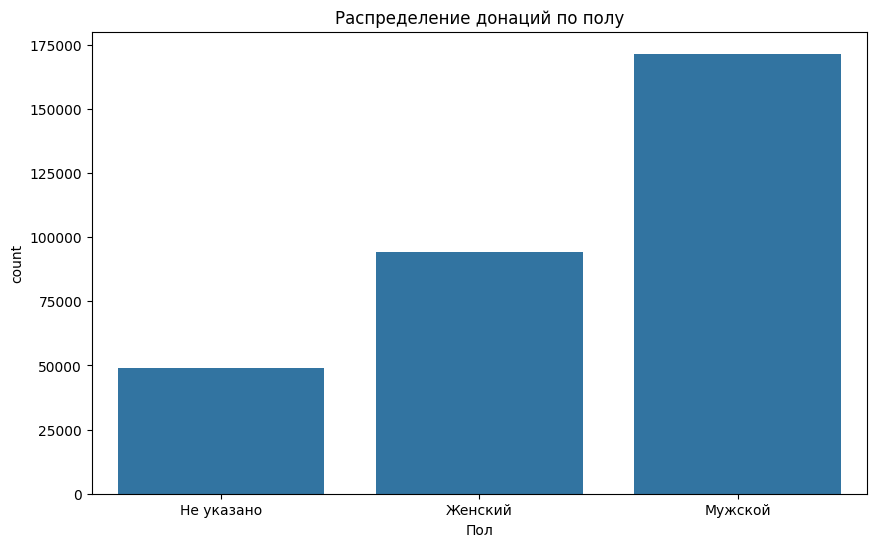

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Пол', data=donors_data)
plt.title('Распределение донаций по полу')
plt.show()



> На графике видно, что мужчины сдают кровь значительно чаще, чем женщины



**Анализ распределения по возрасту**

Функция определения возраста донора с исключением аномальных чисел (От 18 до 65 лет - Всемирная Организация Здравохранения)

In [15]:
def get_age(x):
    if x == 'Не указано':
        return None
    else:
        age = datetime.date.today().year - datetime.date(int(x[6:10]), int(x[3:5]), int(x[0:2])).year
        # убираем аномальный возраст
        age = age if (18 <= age <= 65) else None
        return age

Определение возраста донара

In [16]:
donors_data['Возраст'] = donors_data['Дата рождения'].apply(lambda x: get_age(x))

Построение графика

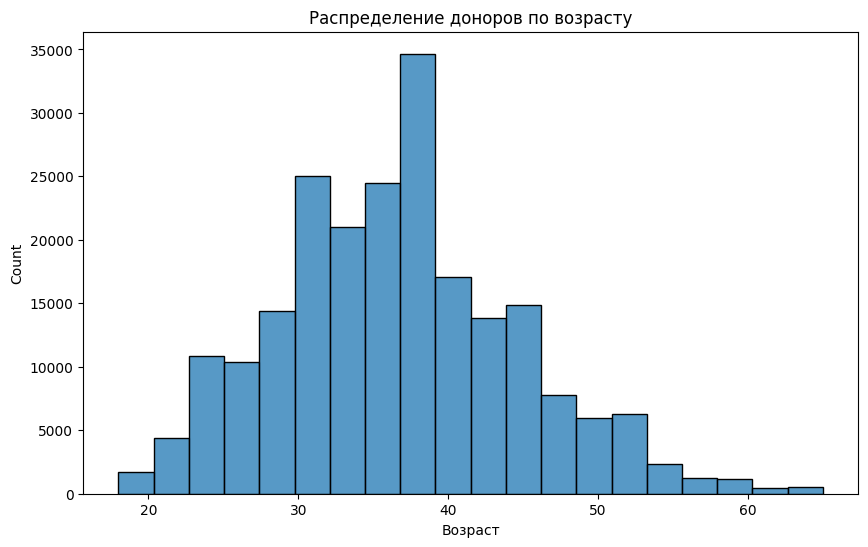

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(donors_data['Возраст'].dropna(), bins=20)
plt.title('Распределение доноров по возрасту')
plt.show()



> На графике видно, что основная возрастная группа активных доноров составляет от 30 до 40 лет



**Анализ распределения по регионам**

Заполние регионов городами административного значения

In [18]:
def fill_region(rw):
    return rw['Город'] if rw['Регион_y'] == 'Не указан' else rw['Регион_y']

donors_data['Регион'] = donors_data.apply(lambda rw: fill_region(rw), axis=1)

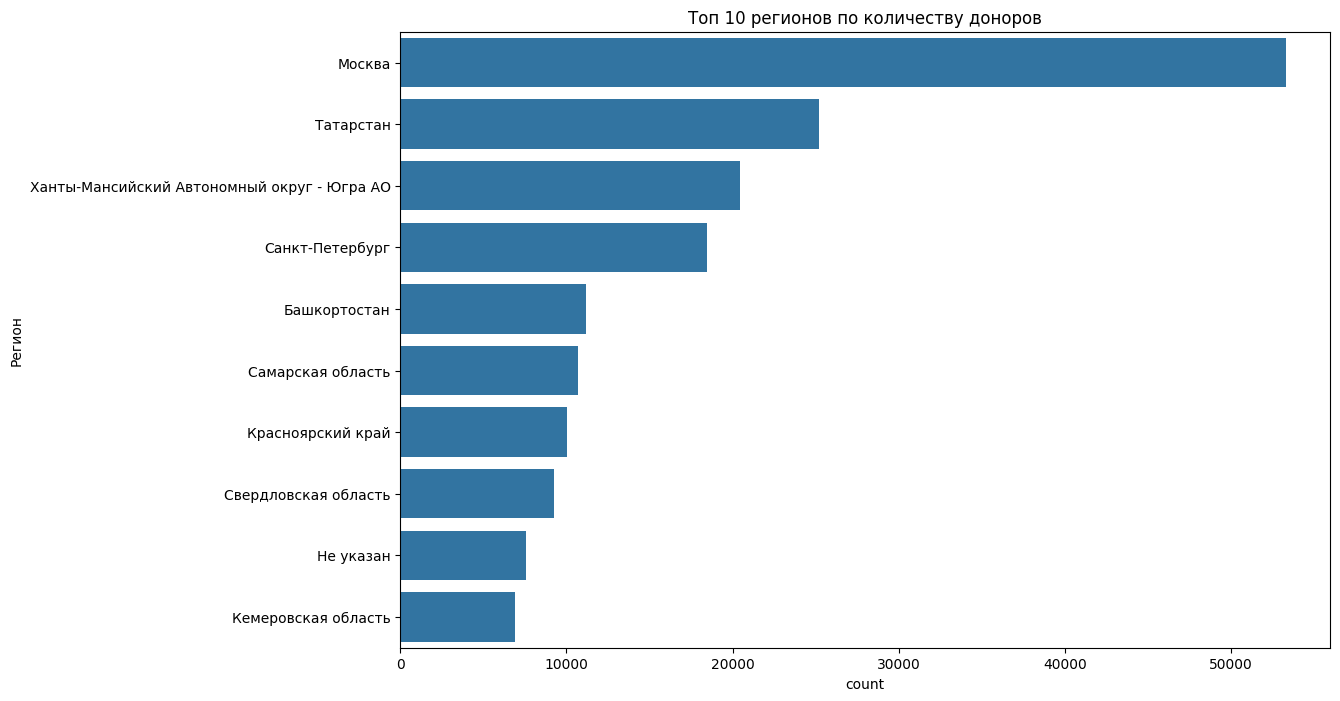

In [19]:
plt.figure(figsize=(12, 8))
top_regions = donors_data['Регион'].value_counts().head(10).index
sns.countplot(y='Регион', data=donors_data[donors_data['Регион'].isin(top_regions)],
              order=donors_data['Регион'].value_counts(ascending=False).head(10).index)
plt.title('Топ 10 регионов по количеству доноров')
plt.show()



> На графике видно, что доноры в основном сосредоточены в крупных городах и развитых регионах



### Анализ жертвователей

Объединение данных пользователей и данных о пожертвованиях по идентификатору пользователя

In [20]:
clients_anon['ID пользователя'] = pd.to_numeric(clients_anon['ID пользователя'], errors='coerce')

donors_clients_data = pd.merge(clients_anon, fundraisings_anon, left_on='ID пользователя',
                               right_on='ID пользователя', how='inner')

**Анализ распределения по возрасту**

Функция определения возраста жертвователя с исключением аномальных чисел (только платежеспособное население)

In [21]:
def get_age_2(x):
    if x == 'Не указано':
        return None
    else:
        age = datetime.date.today().year - datetime.date(int(x[0:4]), int(x[5:7]), int(x[8:10])).year
        # убираем аномальный возраст
        age = age if (18 <= age <= 99) else None
        return age

Определение возраста жертвователя

In [22]:
donors_clients_data['Возраст'] = donors_clients_data['Дата рождения'].apply(lambda x: get_age_2(x))

Построение графика

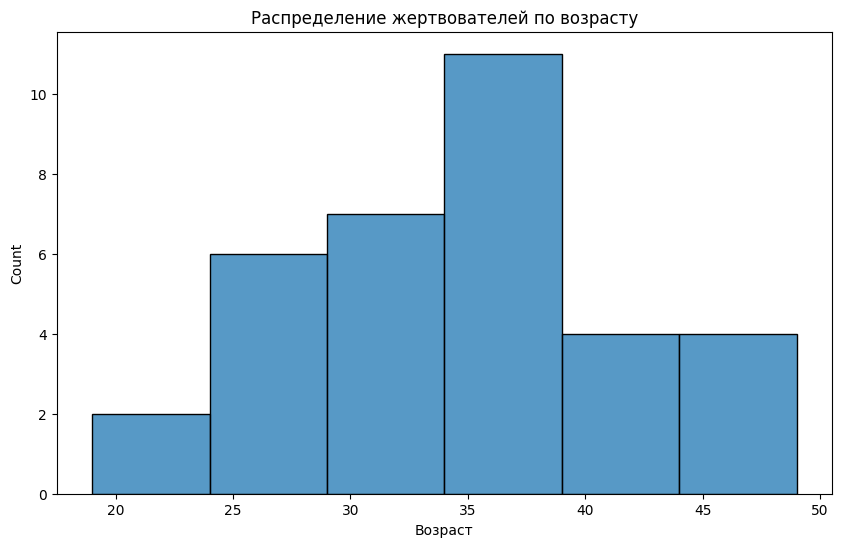

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(donors_clients_data['Возраст'].dropna(), bins=6)
plt.title('Распределение жертвователей по возрасту')
plt.show()



> На графике видно, что основная возрастная группа активных жертвователей составляет от 25 до 40 лет



**Анализ распределения по взносам (пожертвованиям)**

Групировка пожертвований по пользователям. Определение ТОП-5 пользователей по внесенным суммам

In [24]:
top_clients = donors_clients_data.groupby('ID пользователя')['Собрано'].sum().sort_values(ascending=False)
palette_color = sns.color_palette('bright')
l_data = top_clients.tolist()[0:5]
l_data.append(sum(top_clients.tolist()[5:]))
l_label = list(map(str, list(map(int, top_clients.index.values.tolist()[0:5]))))
l_label.append('Other')

Построение графика

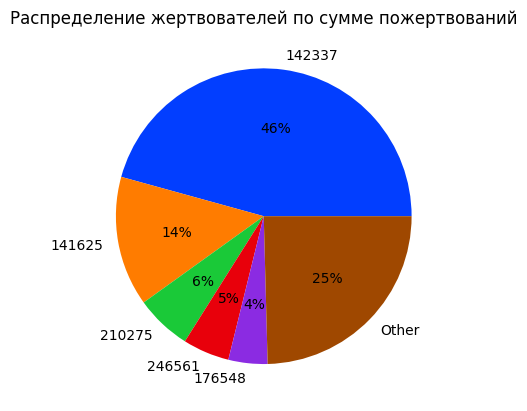

In [25]:
plt.pie(l_data, labels=l_label, colors=palette_color, autopct='%.0f%%')
plt.title('Распределение жертвователей по сумме пожертвований')
plt.show()



> На графике видно, что 5 пользователей жертвуют 75% всех собранных средств. Это, как и сказано ранее, не дает возможности объективно осуществить анализ. Нет достаточной статистической популяции.



## Метрики результатов деятельности DonorSearch

Удаление аномальных дат

In [26]:
donations_anon = donations_anon[donations_anon['Дата донации'] <= pd.Timestamp.today()]
fundraisings_anon = fundraisings_anon[fundraisings_anon['Дата начала сбора'] <= pd.Timestamp.today()]

### DAU и MAU
* Daily Active Users (DAU) - ежедневное количество активных пользователей.
* Monthly Active Users (MAU) - ежемесячное количество активных пользователей

**Расчет DAU**

In [27]:
donations_anon['date'] = donations_anon['Дата донации'].dt.date
fundraisings_anon['date'] = fundraisings_anon['Дата начала сбора'].dt.date
dau_donations = donations_anon.groupby('date').size().reset_index(name='DAU')
dau_fundraisings = fundraisings_anon.groupby('date').size().reset_index(name='DAU')

Представление результатов

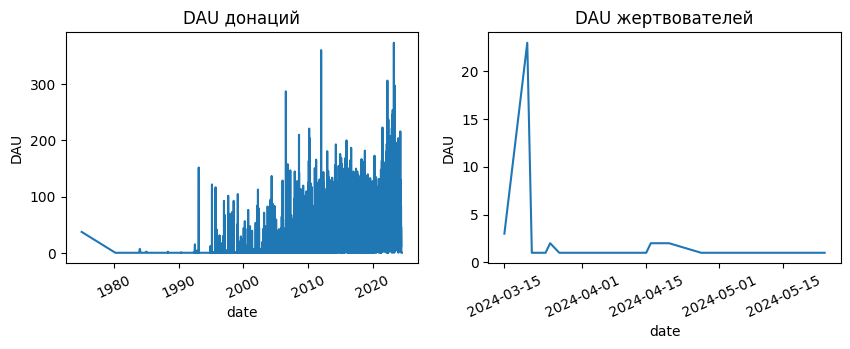

In [28]:
plt.figure(figsize=(10, 3))
plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.subplot(1, 2, 1)
sns.lineplot(x = "date", y = "DAU", data = dau_donations)
plt.xticks(rotation = 25)
plt.title('DAU донаций')

plt.subplot(1, 2, 2)
sns.lineplot(x = "date", y = "DAU", data = dau_fundraisings)
plt.xticks(rotation = 25)
plt.title('DAU жертвователей')
plt.show()



> На графиках видно, что DAU показывает наличие пиков активности в определенные дни. Эти пики могут быть связаны с проведением специальных акций, кампаний по привлечению доноров и жертвователей, а также с коммуникационными активностями, направленными на пользователей платформы.



**Расчет MAU**

In [29]:
donations_anon['month'] = donations_anon['Дата донации'].dt.to_period('M')
fundraisings_anon['month'] = fundraisings_anon['Дата начала сбора'].dt.to_period('M')
mau_donations = donations_anon.groupby('month').size().reset_index(name='MAU')
mau_fundraisings = fundraisings_anon.groupby('month').size().reset_index(name='MAU')

Представление результатов

In [30]:
# Подготовка X-лайнов
mau_donations['month'] = mau_donations['month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
mau_fundraisings['month'] = mau_fundraisings['month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

Демонстрация результатов

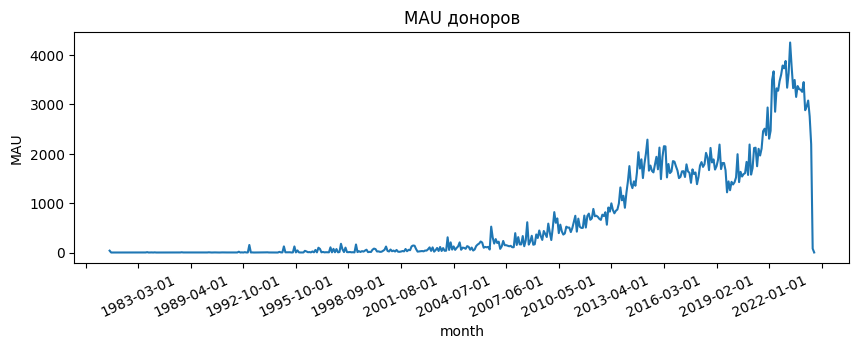

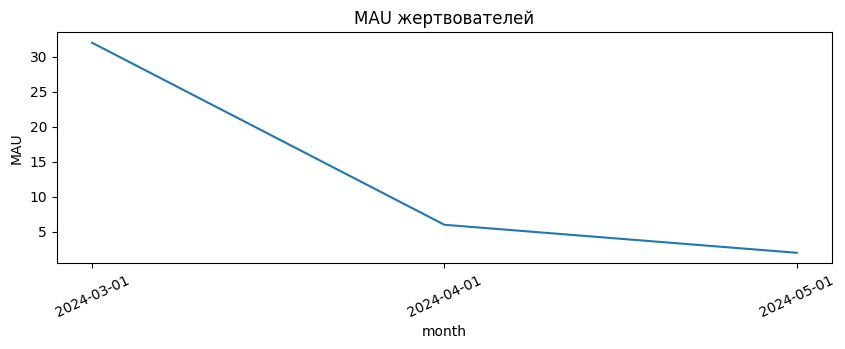

In [31]:
fig, ax = plt.subplots(figsize=(10, 3))
#plt.plot(mau_donations['month'].to_list(), mau_donations['MAU'].to_list())
sns.lineplot(x = "month", y = "MAU", data = mau_donations)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
plt.xticks(rotation = 25)
plt.title('MAU доноров')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(x = "month", y = "MAU", data = mau_fundraisings)
plt.xticks(rotation = 25)
plt.title('MAU жертвователей')
plt.show()




> На графиках видно, что ежемесячная (MAU) активность доноров показывает стабильные донаций, но прослеживается существенное снижение в части пожертвований



### LTV

*   Общая ценность пользователей для платформы за все время их взаимодействия



Расчет средней суммы пожертвований

In [32]:
avg_fundraising_amount = fundraisings_anon['Собрано'].mean()

Среднее количество пожертвований на одного пользователя

In [33]:
fundraisings_per_user = fundraisings_anon.groupby('ID пользователя').size().mean()

Расчет средней продолжительности жизни пользователя на платформе (в днях)

In [34]:
user_lifetime_fundraisings = fundraisings_anon.groupby('ID пользователя').agg({'Дата начала сбора': [min, max]})
user_lifetime_fundraisings.columns = ['min_date', 'max_date']
user_lifetime_fundraisings['lifetime_days'] = (user_lifetime_fundraisings['max_date'] - user_lifetime_fundraisings['min_date']).dt.days
avg_lifetime_days_fundraisings = user_lifetime_fundraisings['lifetime_days'].mean()

**Расчет LTV**

In [35]:
avg_lifetime_years_fundraisings = avg_lifetime_days_fundraisings / 365
ltv_fundraisings = avg_fundraising_amount * fundraisings_per_user * avg_lifetime_years_fundraisings

Вывод результатов

In [36]:
print(f"Средняя сумма пожертвования: {round(avg_fundraising_amount, 2)}")
print(f"Среднее количество пожертвований на одного пользователя: {round(fundraisings_per_user, 2)}")
print(f"Средняя продолжительность жизни пользователя на платформе {round(avg_lifetime_days_fundraisings, 2)} дней ")
print(f"LTV для жертвователей: {round(ltv_fundraisings)}")

Средняя сумма пожертвования: 6240.58
Среднее количество пожертвований на одного пользователя: 1.08
Средняя продолжительность жизни пользователя на платформе 2.14 дней 
LTV для жертвователей: 39


### Retention Rate



*   Retention Rate показывает, сколько жертвователей возвращаются на платформу через определенный промежуток времени.



Определение когорты пользователей (месяц первой активности)

In [37]:
fundraisings_anon['cohort'] = fundraisings_anon.groupby('ID пользователя')['Дата начала сбора'].transform('min').dt.to_period('M')

In [38]:
fundraisings_anon['cohort'] = fundraisings_anon['cohort'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

Определение месяцев активности

In [39]:
fundraisings_anon['active_month'] = fundraisings_anon['Дата начала сбора'].dt.to_period('M')

Количество пользователей в когортах и их активность в последующие месяцы

In [40]:
cohort_counts_fundraisings = fundraisings_anon.groupby(['cohort', 'active_month']).agg(n_users=('ID пользователя', 'nunique')).reset_index()

In [41]:
cohort_counts_fundraisings['active_month'] = cohort_counts_fundraisings['active_month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

Поворот таблиц для вычисления Retention Rate

In [42]:
cohort_pivot_fundraisings = cohort_counts_fundraisings.pivot_table(index='cohort', columns='active_month', values='n_users')

Размеры когорт (количество уникальных пользователей в когорте)

In [43]:
cohort_sizes_fundraisings = cohort_pivot_fundraisings.iloc[:, 0]

Расчет Retention Rate

In [44]:
retention_rate_fundraisings = cohort_pivot_fundraisings.divide(cohort_sizes_fundraisings, axis=0)

Подготовка данных для графика



In [45]:
retention_rate_fundraisings = retention_rate_fundraisings.reset_index().melt(id_vars='cohort', value_name='retention').dropna()

Построение графиков

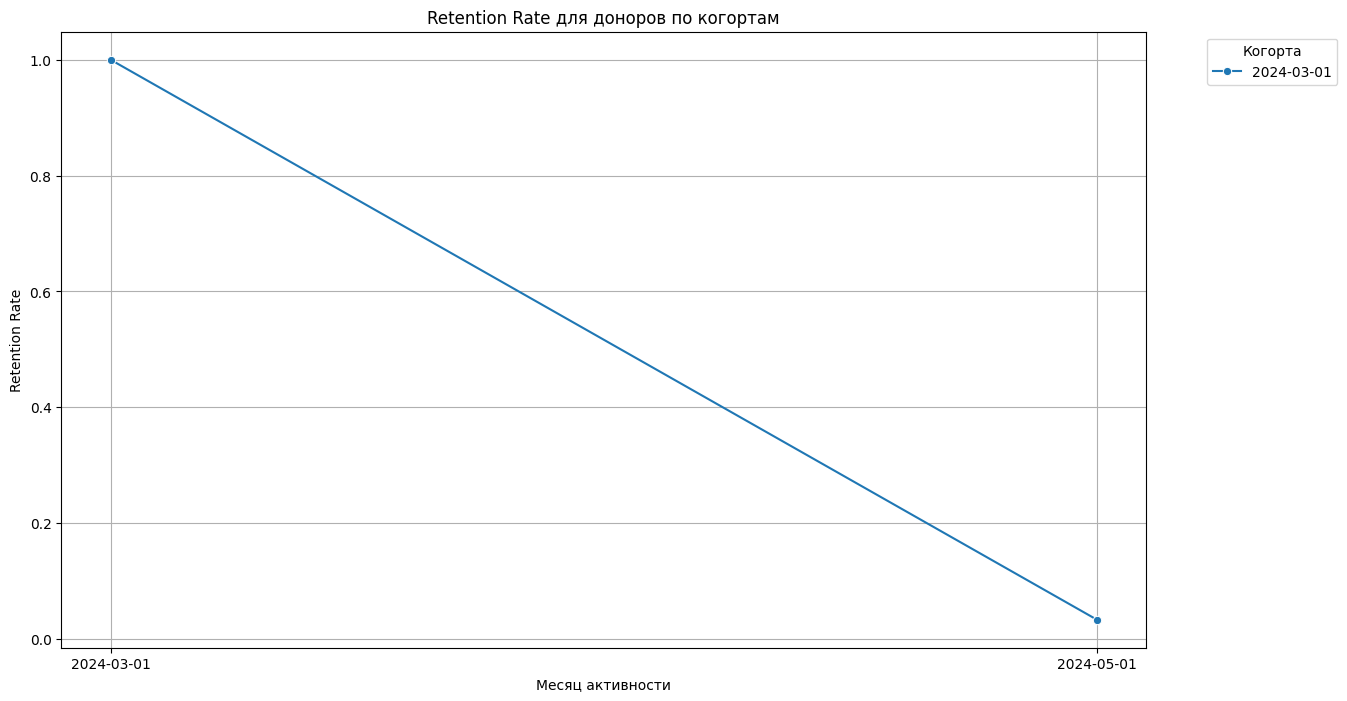

In [46]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=retention_rate_fundraisings, x='active_month', y='retention', hue='cohort', marker='o')
plt.title('Retention Rate для доноров по когортам')
plt.xlabel('Месяц активности')
plt.ylabel('Retention Rate')
plt.legend(title='Когорта', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



> На графике видно, что удержание жертвователей снижается



### Частота донаций и рост суммы пожертвований с течением времени

Частота донаций (в среднем на одного пользователя)

In [47]:
donation_frequency = donations_anon.groupby('ID пользователя').size().mean()

In [48]:
donation_frequency

6.225839609401254

In [49]:
fundraising_amount_summ = fundraisings_anon.groupby('month')['Собрано'].sum().pct_change().fillna(0).reset_index(name='Fundraising Amount Summ')

In [50]:
print(fundraising_amount_summ)

     month  Fundraising Amount Summ
0  2024-03                 0.000000
1  2024-04                -0.985104
2  2024-05                -0.421415




> По данным видно, что сумма пожертвований снижается, но стабилизируется



## Расчет результатов работы DonorSearch

Период: последние 12 месяцев

In [51]:
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(months=12)

Фильтрация данных по выбранному периоду

In [52]:
filtered_donations = donations_anon[(donations_anon['Дата донации'] >= start_date) & (donations_anon['Дата донации'] <= end_date)]
filtered_fundraisings = fundraisings_anon[(fundraisings_anon['Дата начала сбора'] >= start_date) & (fundraisings_anon['Дата начала сбора'] <= end_date)]

Сводная таблица результатов

In [53]:
print(f"Период: {start_date.strftime('%Y-%m-%d')} - {end_date.strftime('%Y-%m-%d')}")
print(f"Количество привлеченных доноров: {filtered_donations['ID пользователя'].nunique()}")
print(f"Количество сделанных донаций: {filtered_donations.shape[0]}")
print(f"Общая сумма собранных пожертвований: {filtered_fundraisings['Собрано'].sum()}")

Период: 2023-07-25 - 2024-07-25
Количество привлеченных доноров: 11979
Количество сделанных донаций: 31257
Общая сумма собранных пожертвований: 249623.0




> Эти результаты демонстрируют успешность работы платформы DonorSearch в привлечении доноров и сборе пожертвований, что способствует достижению поставленных целей.



## Выводы и рекомендации

**Выводы:**
1. Доноры неравномерны по полу, с преобладающей долей мужчин.
2. Основная возрастная группа активных доноров составляет от 30 до 40 лет и от 25 до 40 лет для жертвователей, что соответствует активному и платежеспособному возрасту.
3. Доноры в основном сосредоточены в крупных городах и развитых регионах, что может быть связано с лучшей инфраструктурой и доступностью медицинских учреждений.
4. Преобладают крупные жертователи, которые жертвут 75% из общего числа.
5. За последний год НКО DonorSearch привлекла значительное количество новых доноров, демонстрируя успешную работу по вовлечению новых участников.
6. Ежедневная (DAU) и ежемесячная (MAU) активность доноров показывает стабильное использование платформы, что свидетельствует о высокой заинтересованности и вовлеченности пользователей.
7. Общая сумма собранных пожертвований является значительной, указывая на успех платформы, но темпы пожертвований снижается.

**Рекомендации**
1. Проводите регулярный анализ коэффициента удержания пользователей, чтобы выявлять и устранять потенциальные проблемы.
2. Внедрите программы лояльности для доноров, такие как бонусы или привилегии за повторные донации, чтобы стимулировать их активность.
3. Собирайте обратную связь от текущих доноров для улучшения пользовательского опыта и создания условий, привлекательных для новых участников.
4. Организуйте специальные кампании по сбору средств для конкретных проектов или целей, чтобы вдохновить жертвователей.
5. Разработайте и распространите разъяснительные материалы, показывающие, как пожертвования используются для достижения целей НКО, чтобы расширить круг жертвователей и мотивировать на более крупные взносы.
6. Регулярно анализируйте ключевые метрики и тренды для обоснованных решений и корректировки стратегий.
7. Предоставьте пользователям необходимую поддержку и обучающие материалы, чтобы они могли легко использовать все функции платформы.